# Overview

In this lab, you will complete a handwriten digit recognition  number recognition using a basic feed forward neural network

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip3 install torchmetrics
!pip3 install matplotlib
!pip3 install scipy
!pip3 install scikit-learn

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm
from torch import nn
from tqdm import tqdm
from torch import optim
from torch.nn import functional
import torchmetrics
import statistics
%matplotlib inline

e:\Anaconda\envs\ai_lab3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## introduction to tensors

Tensors are multi-dimensional arrays with a uniform type, here is an example a 3 3-axis tensor

In [2]:
t= torch.tensor(
[
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],]
)

here is what it looks like:

![image](Resources/tensor.png)

Try to  understand it with it's shape:

In [3]:
t.shape

torch.Size([3, 2, 5])

you can switch dimension by transpose them

In [4]:
t_p = torch.transpose(t, 0, 1)
t_p.shape

torch.Size([2, 3, 5])

Or fuse several dimension by reshape it:

In [5]:
t_r = torch.reshape(t, [6, 5])
t_r.shape

torch.Size([6, 5])

**Q:** Please find 2 way to transform the tensor `t` into shape of [10, 3], and state what the different between these two methods

In [6]:
t_result1 = torch.reshape(t, [10, 3])
t_result2 = t.view(10,3)

print("t_result1",t_result1.shape)
print("t_result2",t_result2.shape)

t_result1 torch.Size([10, 3])
t_result2 torch.Size([10, 3])


## Download and load dataset

> MNIST stands for Mixed National Institute of Standards and Technology, which has produced a handwritten digits dataset. This is one of the most researched datasets in machine learning, and is used to classify handwritten digits. This dataset is helpful for predictive analytics because of its sheer size, allowing deep learning to work its magic efficiently. This dataset contains 60,000 training images and 10,000 testing images, formatted as 28 x 28 pixel monochrome images.

here we are using the **DataLoader** to build the input data. The Data loader Combines a dataset and a sampler, and provides an iterable over the given dataset.
It allows us to load data in a small batch at one time, while loading them all at once may make the training process too computationally heavy for your device.

[reference for dataloader](https://pytorch.org/docs/stable/data.html)

In [7]:
batch_size_train = 128
batch_size_test = 128

In [8]:
    #load data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size_test, shuffle=True)

## illustrate example data

here we pick first batch of data, to see what it looks like and its shape when become a tensor.

In [9]:
examples = enumerate(test_loader)
index, (example_data, example_labels) = next(examples)
print(example_data.shape)

torch.Size([128, 1, 28, 28])


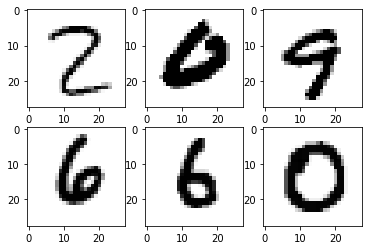

In [9]:
#plot firtst 6 data in in test set
ig, axes = plt.subplots(nrows=2, ncols=3)

for index_row, row_axes in enumerate(axes):
    for index_col, ax in enumerate(row_axes):
        i = index_row*3 + index_col
        ax.imshow(example_data[i].numpy().squeeze(), cmap="Greys")

## Data preprocessing

here we use adjusted standardize for image, in case of the stds become zero. the formula is:

$$
output = \frac{x-\mu}{\hat{\sigma}} \\
\hat{\sigma} = max(\sigma, \frac{1.0}{\sqrt{N}})
$$

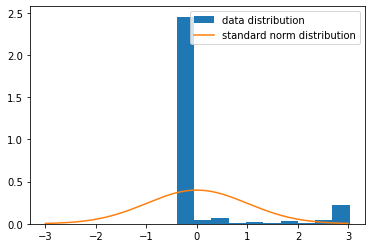

In [10]:
#preprocessing
def standardize(data, dim):
    means = data.mean(dim = dim, keepdims=True)
    stds = data.std(dim = dim, keepdims=True)
    stds = torch.maximum(stds, torch.tensor(1./math.sqrt(28*28)))
    return (data - means) / stds

example_data_standardized = standardize(example_data, dim=(-2, -1))
fig, ax = plt.subplots()
ax.hist(example_data_standardized[0].numpy().flatten(), density=True, label="data distribution")

x = np.arange(-3, 3, 0.01)
ax.plot(x, norm.pdf(x, 0, 1.), label="standard norm distribution")
plt.legend()


## building the feed forward neural network

there are 5 hidden layers. The first 4 layers use Relu for activation, while the last layer use softmax as input

[how to build neural network in pytorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
[category of all pytorch layers(modules)](https://pytorch.org/docs/stable/nn.html#loss-functions)

**Q**: why we need softmax as the last activation function?

In [32]:
model = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Softmax(dim=-1)
)

In [25]:
def create_model():
  model = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Softmax(dim=-1)
  )
  return model

## training the model

we use **cross entropy** as loss function and **stochastic gradient descent(SDG)** as optimizer

[how to train a pytorch model](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

In [33]:
# training a model
def train(model, n_epochs, learning_rate, name):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    testing_accuracy = []
    average_train_loss = []
    for epoch in range(n_epochs):
        highest_accuracy = 0
        accuracy_train = torchmetrics.Accuracy(num_classes=10)
        pbar = tqdm(train_loader, desc="epoch: " + str(epoch))
        batch_loss = []
        for index, (data, label) in enumerate(pbar):
            optimizer.zero_grad()

            x = standardize(data, (-2, -1))
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            y = model(x)

            loss = functional.cross_entropy(y, label)
            loss.backward()
            optimizer.step()

            acu = accuracy_train(y, label).item()
            pbar.set_postfix({
                    'batch_accuracy': acu,
                    'loss': loss.item()
                })
            batch_loss.append(loss.item())

        #add average loss to the list
        average_train_loss.append(statistics.mean(batch_loss))
        #test
        accuracy_test = torchmetrics.Accuracy(num_classes=10)

        for index, (data, label) in enumerate(test_loader):
            x = standardize(data, (-2, -1))
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            y = model(x)
            accuracy_test.update(y, label)

        accu_test = accuracy_test.compute().item()
        print('test_accuracy='+str(accu_test), end=', ')

        #add test loss to the list
        testing_accuracy.append(accu_test)

        #save the model of highest accuracy
        if accu_test > highest_accuracy:
            highest_accuracy = accu_test
            torch.save(model.state_dict(), r"checkpoint"+name)

    return testing_accuracy, average_train_loss

accuracy, losses = train(model, n_epochs=20, learning_rate=1e-1,name="0")

epoch: 0: 100%|██████████| 469/469 [00:07<00:00, 62.30it/s, batch_accuracy=0.281, loss=2.22] 


test_accuracy=0.36090001463890076, 

epoch: 1: 100%|██████████| 469/469 [00:08<00:00, 53.02it/s, batch_accuracy=0.75, loss=1.72] 


test_accuracy=0.7915999889373779, 

epoch: 2: 100%|██████████| 469/469 [00:08<00:00, 53.50it/s, batch_accuracy=0.802, loss=1.66]


test_accuracy=0.8242999911308289, 

epoch: 3: 100%|██████████| 469/469 [00:08<00:00, 53.61it/s, batch_accuracy=0.792, loss=1.67]


test_accuracy=0.8310999870300293, 

epoch: 4: 100%|██████████| 469/469 [00:08<00:00, 53.57it/s, batch_accuracy=0.958, loss=1.51]


test_accuracy=0.9326000213623047, 

epoch: 5: 100%|██████████| 469/469 [00:08<00:00, 53.03it/s, batch_accuracy=0.927, loss=1.53]


test_accuracy=0.9398000240325928, 

epoch: 6: 100%|██████████| 469/469 [00:08<00:00, 53.57it/s, batch_accuracy=1, loss=1.48]    


test_accuracy=0.9534000158309937, 

epoch: 7: 100%|██████████| 469/469 [00:08<00:00, 53.31it/s, batch_accuracy=0.99, loss=1.48] 


test_accuracy=0.9524000287055969, 

epoch: 8: 100%|██████████| 469/469 [00:08<00:00, 52.12it/s, batch_accuracy=0.979, loss=1.49]


test_accuracy=0.9585000276565552, 

epoch: 9: 100%|██████████| 469/469 [00:08<00:00, 54.33it/s, batch_accuracy=0.948, loss=1.51]


test_accuracy=0.9623000025749207, 

epoch: 10: 100%|██████████| 469/469 [00:08<00:00, 52.91it/s, batch_accuracy=0.958, loss=1.51]


test_accuracy=0.9643999934196472, 

epoch: 11: 100%|██████████| 469/469 [00:09<00:00, 52.08it/s, batch_accuracy=0.99, loss=1.49] 


test_accuracy=0.965399980545044, 

epoch: 12: 100%|██████████| 469/469 [00:08<00:00, 52.38it/s, batch_accuracy=0.969, loss=1.5] 


test_accuracy=0.9682999849319458, 

epoch: 13: 100%|██████████| 469/469 [00:09<00:00, 51.98it/s, batch_accuracy=0.99, loss=1.47] 


test_accuracy=0.9624000191688538, 

epoch: 14: 100%|██████████| 469/469 [00:08<00:00, 53.35it/s, batch_accuracy=0.979, loss=1.48]


test_accuracy=0.9697999954223633, 

epoch: 15: 100%|██████████| 469/469 [00:08<00:00, 52.84it/s, batch_accuracy=0.979, loss=1.48]


test_accuracy=0.9695000052452087, 

epoch: 16: 100%|██████████| 469/469 [00:08<00:00, 52.51it/s, batch_accuracy=0.99, loss=1.47] 


test_accuracy=0.9706000089645386, 

epoch: 17: 100%|██████████| 469/469 [00:08<00:00, 52.56it/s, batch_accuracy=1, loss=1.46]    


test_accuracy=0.9692999720573425, 

epoch: 18: 100%|██████████| 469/469 [00:08<00:00, 52.45it/s, batch_accuracy=0.969, loss=1.49]


test_accuracy=0.9707000255584717, 

epoch: 19: 100%|██████████| 469/469 [00:08<00:00, 53.13it/s, batch_accuracy=0.969, loss=1.49]


test_accuracy=0.970300018787384, 

## Evaluation
you can check the training history using these two variables

In [34]:
#draw a plot refecting the change of accuracy and losses relative to the number of epoch
print(accuracy)
print(losses)

[0.36090001463890076, 0.7915999889373779, 0.8242999911308289, 0.8310999870300293, 0.9326000213623047, 0.9398000240325928, 0.9534000158309937, 0.9524000287055969, 0.9585000276565552, 0.9623000025749207, 0.9643999934196472, 0.965399980545044, 0.9682999849319458, 0.9624000191688538, 0.9697999954223633, 0.9695000052452087, 0.9706000089645386, 0.9692999720573425, 0.9707000255584717, 0.970300018787384]
[2.288484105169138, 1.8810189690417065, 1.6573966578888233, 1.6306375099906028, 1.5660995267855842, 1.5258160974425294, 1.5157941658613778, 1.5084314534404892, 1.502488561784789, 1.4973143722965265, 1.4941168271148129, 1.4910657260972044, 1.4882612802834907, 1.4855521858882295, 1.4839331310695167, 1.4827773082993432, 1.481055839992027, 1.4796833087132175, 1.4785417191255321, 1.4777768240300322]


**Q** please draw a plot refecting the change of accuracy and losses relative to the number of epoch

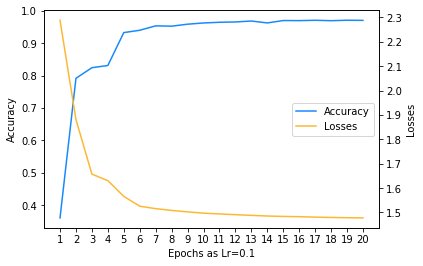

In [42]:
def train_plot(epoach_num,accuracy,losses,learning_rate):
    epochs = np.arange(1,epoach_num+1,1)
    epochs = epochs.astype(np.int16)
    fig, ax = plt.subplots()
    ax1=ax.twinx()
    line1=ax.plot(epochs, accuracy,"#1789FC",label="Accuracy")
    line2=ax1.plot(epochs, losses, "#FDB833",label="Losses")
    lines=line1+line2
    labs = [l.get_label() for l in lines]
    ax1.legend(lines,labs,loc='right')
    ax.set_xlabel("Epochs as Lr="+str(learning_rate))
    ax.set_xlim(0,21)
    ax.set_xticks(epochs)
    ax.set_ylabel("Accuracy")
    ax1.set_ylabel("Losses")
train_plot(20,accuracy,losses,0.1)

**Q** please draw a confusion matrix using test data loader

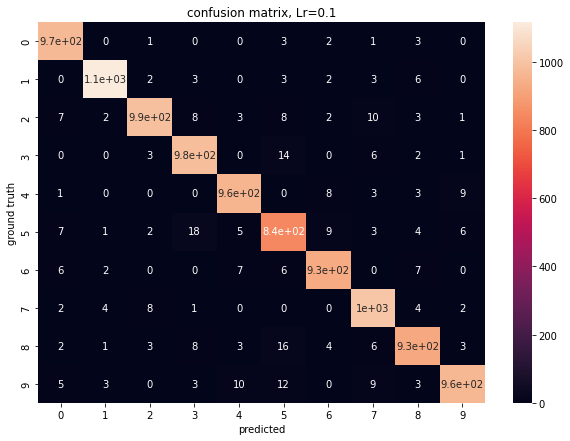

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
#read model for evaluation, using test dataloader to draw
model1=create_model()
model1.load_state_dict(torch.load(r"checkpoint"))
def test_model(test_loader,model,Lr):
    test_label=[]
    prediction=[]
    for index, (data, label) in enumerate(test_loader):
        x = standardize(data, (-2, -1))
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        y = model(x)
        label=label.detach().numpy()
        y=y.detach().numpy()
        pred = np.zeros((len(y),1))
        for i in range(len(y)):
            y0=np.where(y[i]==np.max(y[i]))
            pred[i]=y0[0]
        test_label=np.append(test_label,label)
        prediction=np.append(prediction,pred)
    mat1=confusion_matrix(test_label,prediction)
    plt.figure(figsize = (10,7))
    sn.heatmap(mat1, annot=True)
    title=f"confusion matrix, Lr="+str(Lr)
    plt.title(title)
    plt.ylabel("ground truth")
    plt.xlabel("predicted")
test_model(test_loader,model1,0.1)

# validation

**Q** please use different learning rate to train the model, then comparing the training process by draw a similar plot mentioned above

In [43]:
model2=create_model()
model3=create_model()
accuracy1, losses1 = train(model2, n_epochs=20, learning_rate=0.2,name="1")
accuracy3, losses3 = train(model3, n_epochs=20, learning_rate=0.05,name="2")

epoch: 0: 100%|██████████| 469/469 [00:07<00:00, 61.80it/s, batch_accuracy=0.76, loss=1.7]  


test_accuracy=0.7447999715805054, 

epoch: 1: 100%|██████████| 469/469 [00:07<00:00, 62.59it/s, batch_accuracy=0.875, loss=1.58]


test_accuracy=0.8476999998092651, 

epoch: 2: 100%|██████████| 469/469 [00:07<00:00, 62.26it/s, batch_accuracy=0.896, loss=1.57]


test_accuracy=0.8632000088691711, 

epoch: 3: 100%|██████████| 469/469 [00:07<00:00, 62.32it/s, batch_accuracy=0.885, loss=1.59]


test_accuracy=0.8693000078201294, 

epoch: 4: 100%|██████████| 469/469 [00:07<00:00, 60.88it/s, batch_accuracy=0.906, loss=1.55]


test_accuracy=0.8727999925613403, 

epoch: 5: 100%|██████████| 469/469 [00:07<00:00, 59.91it/s, batch_accuracy=0.917, loss=1.54]


test_accuracy=0.953000009059906, 

epoch: 6: 100%|██████████| 469/469 [00:07<00:00, 60.80it/s, batch_accuracy=0.917, loss=1.54]


test_accuracy=0.9506000280380249, 

epoch: 7: 100%|██████████| 469/469 [00:07<00:00, 61.28it/s, batch_accuracy=0.99, loss=1.48] 


test_accuracy=0.9577000141143799, 

epoch: 8: 100%|██████████| 469/469 [00:07<00:00, 61.06it/s, batch_accuracy=0.969, loss=1.49]


test_accuracy=0.9659000039100647, 

epoch: 9: 100%|██████████| 469/469 [00:07<00:00, 60.80it/s, batch_accuracy=0.979, loss=1.48]


test_accuracy=0.968500018119812, 

epoch: 10: 100%|██████████| 469/469 [00:07<00:00, 60.91it/s, batch_accuracy=0.979, loss=1.49]


test_accuracy=0.968999981880188, 

epoch: 11: 100%|██████████| 469/469 [00:07<00:00, 59.73it/s, batch_accuracy=0.958, loss=1.5] 


test_accuracy=0.9704999923706055, 

epoch: 12: 100%|██████████| 469/469 [00:07<00:00, 61.48it/s, batch_accuracy=0.958, loss=1.5] 


test_accuracy=0.9646999835968018, 

epoch: 13: 100%|██████████| 469/469 [00:07<00:00, 61.94it/s, batch_accuracy=1, loss=1.46]    


test_accuracy=0.9686999917030334, 

epoch: 14: 100%|██████████| 469/469 [00:08<00:00, 53.13it/s, batch_accuracy=0.99, loss=1.48] 


test_accuracy=0.9718000292778015, 

epoch: 15: 100%|██████████| 469/469 [00:08<00:00, 52.58it/s, batch_accuracy=0.99, loss=1.47] 


test_accuracy=0.9711999893188477, 

epoch: 16: 100%|██████████| 469/469 [00:08<00:00, 58.45it/s, batch_accuracy=0.969, loss=1.49]


test_accuracy=0.9731000065803528, 

epoch: 17: 100%|██████████| 469/469 [00:07<00:00, 61.91it/s, batch_accuracy=0.99, loss=1.48] 


test_accuracy=0.9700000286102295, 

epoch: 18: 100%|██████████| 469/469 [00:07<00:00, 64.84it/s, batch_accuracy=0.99, loss=1.47] 


test_accuracy=0.9731000065803528, 

epoch: 19: 100%|██████████| 469/469 [00:07<00:00, 62.30it/s, batch_accuracy=0.99, loss=1.47] 


test_accuracy=0.9740999937057495, 

epoch: 0: 100%|██████████| 469/469 [00:07<00:00, 60.08it/s, batch_accuracy=0.229, loss=2.3] 


test_accuracy=0.23659999668598175, 

epoch: 1: 100%|██████████| 469/469 [00:07<00:00, 61.46it/s, batch_accuracy=0.292, loss=2.2]  


test_accuracy=0.34290000796318054, 

epoch: 2: 100%|██████████| 469/469 [00:07<00:00, 61.87it/s, batch_accuracy=0.688, loss=1.81]


test_accuracy=0.6886000037193298, 

epoch: 3: 100%|██████████| 469/469 [00:07<00:00, 61.52it/s, batch_accuracy=0.781, loss=1.67]


test_accuracy=0.73580002784729, 

epoch: 4: 100%|██████████| 469/469 [00:07<00:00, 61.68it/s, batch_accuracy=0.781, loss=1.69]


test_accuracy=0.8302000164985657, 

epoch: 5: 100%|██████████| 469/469 [00:07<00:00, 62.34it/s, batch_accuracy=0.76, loss=1.69] 


test_accuracy=0.845300018787384, 

epoch: 6: 100%|██████████| 469/469 [00:07<00:00, 61.36it/s, batch_accuracy=0.865, loss=1.6] 


test_accuracy=0.8539999723434448, 

epoch: 7: 100%|██████████| 469/469 [00:08<00:00, 57.46it/s, batch_accuracy=0.854, loss=1.6] 


test_accuracy=0.8539000153541565, 

epoch: 8: 100%|██████████| 469/469 [00:08<00:00, 52.98it/s, batch_accuracy=0.823, loss=1.64]


test_accuracy=0.8539000153541565, 

epoch: 9: 100%|██████████| 469/469 [00:08<00:00, 52.81it/s, batch_accuracy=0.812, loss=1.64]


test_accuracy=0.8616999983787537, 

epoch: 10: 100%|██████████| 469/469 [00:08<00:00, 52.39it/s, batch_accuracy=0.823, loss=1.64]


test_accuracy=0.8654000163078308, 

epoch: 11: 100%|██████████| 469/469 [00:08<00:00, 55.19it/s, batch_accuracy=0.885, loss=1.57]


test_accuracy=0.8669999837875366, 

epoch: 12: 100%|██████████| 469/469 [00:07<00:00, 61.07it/s, batch_accuracy=0.875, loss=1.58]


test_accuracy=0.8693000078201294, 

epoch: 13: 100%|██████████| 469/469 [00:07<00:00, 61.31it/s, batch_accuracy=0.792, loss=1.66]


test_accuracy=0.8701000213623047, 

epoch: 14: 100%|██████████| 469/469 [00:07<00:00, 60.84it/s, batch_accuracy=0.865, loss=1.6] 


test_accuracy=0.8729000091552734, 

epoch: 15: 100%|██████████| 469/469 [00:08<00:00, 57.67it/s, batch_accuracy=0.906, loss=1.56]


test_accuracy=0.8715000152587891, 

epoch: 16: 100%|██████████| 469/469 [00:07<00:00, 61.34it/s, batch_accuracy=0.938, loss=1.52]


test_accuracy=0.8745999932289124, 

epoch: 17: 100%|██████████| 469/469 [00:07<00:00, 61.38it/s, batch_accuracy=0.865, loss=1.6] 


test_accuracy=0.8762999773025513, 

epoch: 18: 100%|██████████| 469/469 [00:08<00:00, 57.75it/s, batch_accuracy=0.875, loss=1.59]


test_accuracy=0.8781999945640564, 

epoch: 19: 100%|██████████| 469/469 [00:07<00:00, 59.47it/s, batch_accuracy=0.896, loss=1.57]


test_accuracy=0.8787999749183655, 

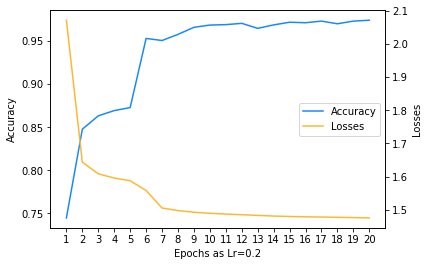

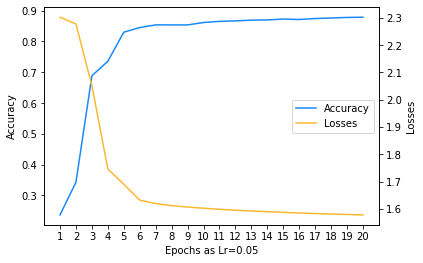

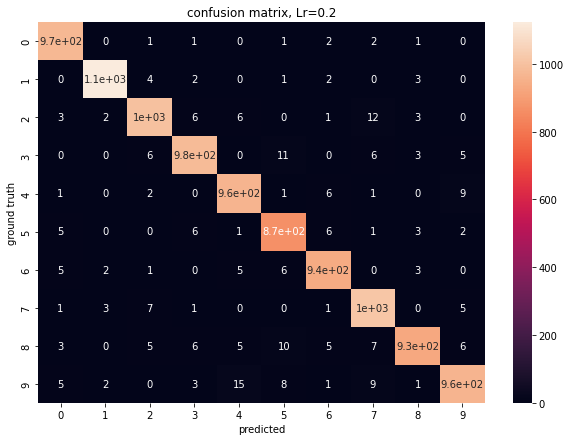

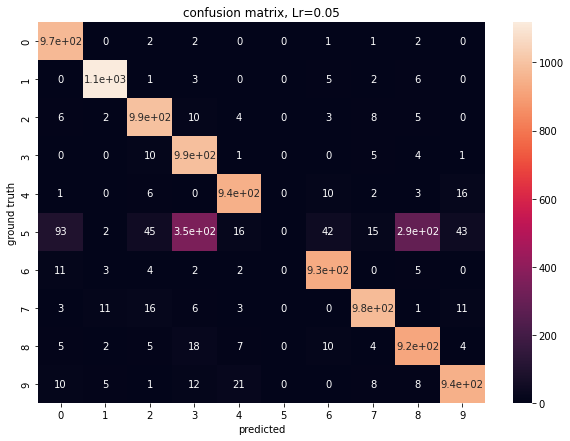

In [46]:
train_plot(20,accuracy1,losses1,0.2)
train_plot(20,accuracy3,losses3,0.05)
test_model(test_loader,model2,Lr=0.2)
test_model(test_loader,model3,Lr=0.05)

In [ ]:
123
456
789